In [72]:
import numpy as np
from scipy.optimize import fsolve 

import matplotlib.pyplot as plt

In [73]:
def electroneut(N_i, K_i, C_i, z_x, X):
    electroneut = (N_i + K_i - C_i) + z_x * X

    return electroneut

def osmoticbal(N_i, K_i, C_i, X, N_b, K_b, C_b, N_a, K_a, C_a):
    osmoticbal = N_b + K_b + C_b - 2*(N_i + K_i + C_i + (X)) + N_a + K_a + C_a

    return osmoticbal

def NaKATPase(N_i, K_na, P, K_a, K_k, K_i, N_a):
    NaKATPase = P * ((N_i / (K_na + N_i))**3) * (K_a / (K_k + K_a))**2

    return NaKATPase

def Cotransporter(M, N_i, K_i, C_i, N_a, K_a, C_a):
    
    # Making the variables more precise. 
    M = np.float64(M)
    N_i = np.float64(N_i)
    K_i = np.float64(K_i)
    C_i = np.float64(C_i)
    N_a = np.float64(N_a)
    K_a = np.float64(K_a)
    C_a = np.float64(C_a)

    ratio = (N_i * K_i * (C_i)**2) / (N_a * K_a * (C_a)**2)
    
    Cotransporter = M * np.log(ratio)
    
    return Cotransporter

def GHKflux(z, Ps_k, Vsm, ns_k, nm_k):
    frt = 37.435883507802615 # Using F, R and T from Mariia's paper
    GHKflux = z * Ps_k * (frt) * Vsm * ((ns_k - nm_k * np.exp((-z * frt * Vsm)))/(1 - np.exp((-z * frt * Vsm))))

    return GHKflux


In [74]:
# Standard parameters
P = 10**(-6) # Non-dimensional
z_x = 1.5 # Non-dimensional
M = 3 * 10**(-6) 
z_k = 1 # Non-dimensional
z_c = -1 # Non-dimensional

#Permeabilities
Pa_K = 5*10**(-7)
Pb_K = 1.5*10**(-7)
Ptj_K = 10**(-6)
Pa_C = 0
Pb_C = 0.8*10**(-8)
Ptj_C = 0

#Concentration, and derived values
N_a = 0.120
K_a = 0.005 
C_a = 0.125
N_b = 0.120
K_b =  0.005
C_b = 0.125
K_na = 0.02692677070828331 # 0.2 * ((1 + K_i)/8.33)
K_k = 0.006054054054054055 # 0.1 * ((1 + N_a)/18.5)

# Variables we want are: N_i, K_i, C_i, X, V

In [75]:
#Defining the whole system

def sys(vars, pars = None):
    N_i, K_i, C_i, X, V = vars

    eq1 = np.float64(-3 * NaKATPase(N_i, K_na, P, K_a, K_k, K_i, N_a) + Cotransporter(M, N_i, K_i, C_i, N_a, K_a, C_a))
    eq2 = np.float64(-1 * GHKflux(z_k, Pa_K, V, K_i, K_a) - GHKflux(z_k, Pb_K, V, K_i, K_b) + 2 * NaKATPase(N_i, K_na, P, K_a, K_k, K_i, N_a) + Cotransporter(M, N_i, K_i, C_i, N_a, K_a, C_a))
    eq3 = np.float64(2 * Cotransporter(M, N_i, K_i, C_i, N_a, K_a, C_a) - GHKflux(z_c, Pb_C, V, C_i, C_b))
    eq4 = np.float64(electroneut(N_i, K_i, C_i, z_x, X))
    eq5 = np.float64(osmoticbal(N_i, K_i, C_i, X, N_b, K_b, C_b, N_a, K_a, C_a))

    return [eq1, eq2, eq3, eq4, eq5]

#Initial guess
initial_guess = [0.018, 0.120, 0.05, 0.1, 0.014]

#Solving the system
solution = fsolve(sys, initial_guess)

print(f"Solution: $Na_i$ = {solution[0]}, $K_i$ = {solution[1]}, $Cl_i$ = {solution[2]}, X = {solution[3]}, V = {solution[4]}")

Solution: $Na_i$ = 0.018, $K_i$ = 0.12, $Cl_i$ = 0.05, X = 0.1, V = 0.014


/var/folders/kg/6qgzh1c962vg2xt2n9swng0h0000gn/T/ipykernel_19004/2892165400.py:29: RuntimeWarning: invalid value encountered in log
  Cotransporter = M * np.log(ratio)


/var/folders/kg/6qgzh1c962vg2xt2n9swng0h0000gn/T/ipykernel_19004/2892165400.py:29: RuntimeWarning: invalid value encountered in log
  Cotransporter = M * np.log(ratio)
/var/folders/kg/6qgzh1c962vg2xt2n9swng0h0000gn/T/ipykernel_19004/2892165400.py:35: RuntimeWarning: overflow encountered in exp
  GHKflux = z * Ps_k * (frt) * Vsm * ((ns_k - nm_k * np.exp((-z * frt * Vsm)))/(1 - np.exp((-z * frt * Vsm))))
/var/folders/kg/6qgzh1c962vg2xt2n9swng0h0000gn/T/ipykernel_19004/2892165400.py:35: RuntimeWarning: invalid value encountered in scalar divide
  GHKflux = z * Ps_k * (frt) * Vsm * ((ns_k - nm_k * np.exp((-z * frt * Vsm)))/(1 - np.exp((-z * frt * Vsm))))


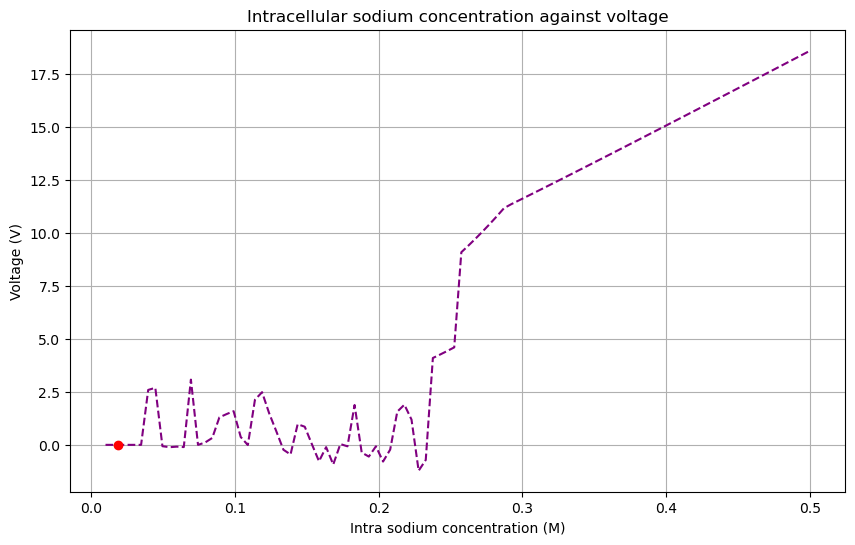

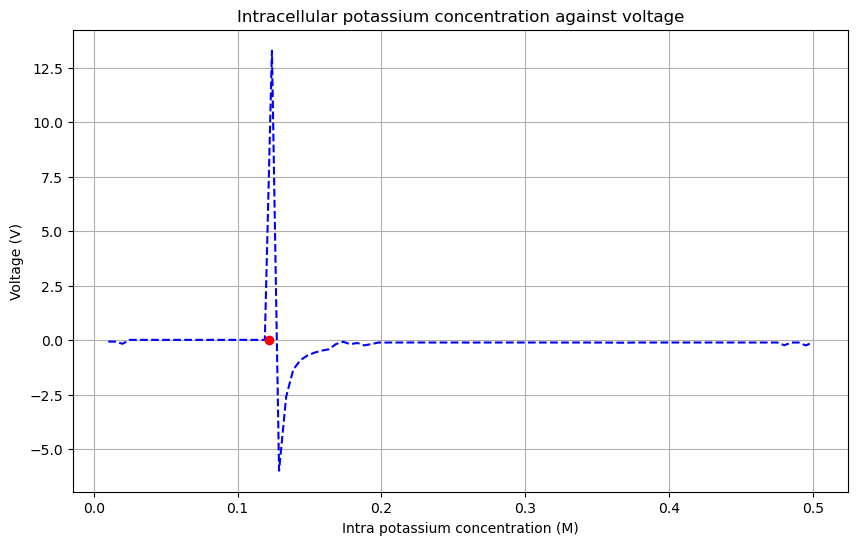

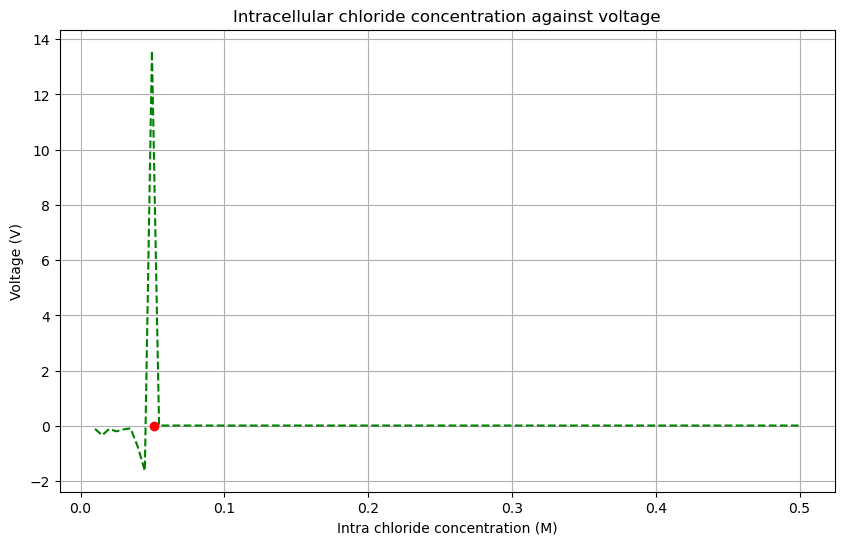

-1.9710139297819823e-05

In [76]:
# With this error we can see that the equation for the cotransporter is the issue, so what we can do is cycle through each ion on a plot...
# ... and set the other concentrations from Mariia's paper. Starting with sodium. 

Na = np.linspace(0.01, 0.5, 100)

solutionfix1 = np.zeros((len(Na), 5))

for i in range(len(Na)):

    # Initial guess, we set X as 0.1 as a guess.
    initial_guessfix1 = [Na[i], 0.1215, 0.051, 0.1, 0.0146]

    solutionfix1[i, :] = fsolve(sys, initial_guessfix1)

plt.figure(figsize=(10, 6))
plt.plot(Na, solutionfix1[:, 4], color='purple', linestyle='--')
plt.plot(0.0185, 0.0146, 'ro')
plt.xlabel('Intra sodium concentration (M)')
plt.ylabel('Voltage (V)')
plt.title('Intracellular sodium concentration against voltage')
plt.grid(True)
plt.show()

# Now trying the same with Potassium

K = np.linspace(0.01, 0.5, 100)

solutionfix2 = np.zeros((len(K), 5))

for i in range(len(K)):

    initial_guessfix2 = [0.0185, K[i], 0.051, 0.1, 0.0146]

    solutionfix2[i, :] = fsolve(sys, initial_guessfix2)

plt.figure(figsize=(10, 6))
plt.plot(Na, solutionfix2[:, 4], color='blue', linestyle='--')
plt.plot(0.1215, 0.0146, 'ro')
plt.xlabel('Intra potassium concentration (M)')
plt.ylabel('Voltage (V)')
plt.title('Intracellular potassium concentration against voltage')
plt.grid(True)
plt.show()

# Finally, trying the same with Chloride

Cl = np.linspace(0.01, 0.5, 100)

solutionfix3 = np.zeros((len(Cl), 5))

for i in range(len(Cl)):

    initial_guessfix3 = [0.0185, 0.1215, Cl[i], 0.1, 0.0146]

    solutionfix3[i, :] = fsolve(sys, initial_guessfix3)

plt.figure(figsize=(10, 6))
plt.plot(Na, solutionfix3[:, 4], color='green', linestyle='--')
plt.plot(0.051, 0.0146, 'ro')
plt.xlabel('Intra chloride concentration (M)')
plt.ylabel('Voltage (V)')
plt.title('Intracellular chloride concentration against voltage')
plt.grid(True)
plt.show()


# Note that I have put small red circles in the spaces that align with Mariia's paper. Since this exists on both plots, we know that the system isn't incorrect...
# ... however, the behaviour around the plots can tell us something. I just haven't figured out what yet.

# Also, my precision with the np.float64 isn't universal as I was just trying to solve one thing. What this asymmetry in precision has done is mess up the plots a little...
# ... we should be seeing the red dots on the line plotted. This will be fixed.

# Testing our desired parameter values to see where the invalid log is, as these concentration plots don't help.

((( 0.0185) * 0.1215 * (0.051))**2) / (N_a * K_a * (C_a)**2)

M * np.log(0.0014017323245399996)

# This implies we need to correct for negative.


In [77]:
# Redefining the general equations, trying to fix the Cotransporter. 

def electroneut(N_i, K_i, C_i, z_x, X):
    electroneut = (N_i + K_i - C_i) + z_x * X

    return electroneut

def osmoticbal(N_i, K_i, C_i, X, N_b, K_b, C_b, N_a, K_a, C_a):
    osmoticbal = N_b + K_b + C_b - 2*(N_i + K_i + C_i + (X)) + N_a + K_a + C_a

    return osmoticbal

def NaKATPase(N_i, K_na, P, K_a, K_k, K_i, N_a):
    NaKATPase = P * ((N_i / (K_na + N_i))**3) * (K_a / (K_k + K_a))**2

    return NaKATPase

def CotransporterFixed(M, N_i, K_i, C_i, N_a, K_a, C_a):

    ratio = ((N_i * K_i * (C_i)**2) / (N_a * K_a * (C_a)**2))

    epsilon = 1 * 10**(-20)

    if ratio <= 0:
        ratio = 0 + epsilon
    
    # really unsure how to deal with the invalid arguments put into the log. When fixing them to positive (via epsilon if then statement) we get incorrect outputs.
    CotransporterFixed = M * np.log(ratio)
    
    return CotransporterFixed

def GHKflux(z, Ps_k, Vsm, ns_k, nm_k):
    frt = 37.435883507802615 # Using F, R and T from Mariia's paper
    GHKflux = z * Ps_k * (frt) * Vsm * ((ns_k - nm_k * np.exp((-z * frt * Vsm)))/(1 - np.exp((-z * frt * Vsm))))

    return GHKflux


In [78]:
#The whole system again with the new Cotransporter defintion.

def sys(vars, pars = None):
    N_i, K_i, C_i, X, V = vars

    eq1 = -3 * NaKATPase(N_i, K_na, P, K_a, K_k, K_i, N_a) + CotransporterFixed(M, N_i, K_i, C_i, N_a, K_a, C_a)
    eq2 = -1 * GHKflux(z_k, Pa_K, V, K_i, K_a) - GHKflux(z_k, Pb_K, V, K_i, K_b) + 2 * NaKATPase(N_i, K_na, P, K_a, K_k, K_i, N_a) + CotransporterFixed(M, N_i, K_i, C_i, N_a, K_a, C_a)
    eq3 = 2 * CotransporterFixed(M, N_i, K_i, C_i, N_a, K_a, C_a) - GHKflux(z_c, Pb_C, V, C_i, C_b)
    eq4 = electroneut(N_i, K_i, C_i, z_x, X)
    eq5 = osmoticbal(N_i, K_i, C_i, X, N_b, K_b, C_b, N_a, K_a, C_a)

    return [eq1, eq2, eq3, eq4, eq5]

#Initial guess
initial_guess = [0.018, 0.120, 0.05, 0.1, 0.014]

#Solving the system
solution = fsolve(sys, initial_guess)

print(f"Solution: $Na_i$ = {solution[0]}, $K_i$ = {solution[1]}, $Cl_i$ = {solution[2]}, X = {solution[3]}, V = {solution[4]}")

#As can be seen, the solution is incorrect here. So it must be an issue with the setup.

Solution: $Na_i$ = -0.0030615616091932848, $K_i$ = -0.10376001471651074, $Cl_i$ = 0.17136431525875095, X = 0.18545726111970867, V = -0.09207811179093596
